## Calculate differences
- Calculate differences using different models on the effect of Trauma vs. Sad on hippocampus

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# regular GLMs
#import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
## Load amygdala database
df = pd.read_csv('amg_TraumavsNeutral.csv')#('TraumavsNeutral_threeSes.csv')
# create a long format for analysis
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['hippo1','hippo2','hippo3'])
df_long#.to_csv('hippo_df_long1.csv', index=False)

,scr_id,groupIdx,variable,value
0,KPE008,1,hippo1,0.464944
1,KPE1223,1,hippo1,0.088564
2,KPE1253,0,hippo1,-0.182786
3,KPE1263,0,hippo1,-0.387857
4,KPE1293,1,hippo1,0.085905
...,...,...,...,...
76,KPE1561,0,hippo3,0.102486
77,KPE1573,1,hippo3,0.529858
78,KPE1578,0,hippo3,0.049309
79,KPE1587,1,hippo3,NaN


In [13]:
## Start with simple GLM models (using statsmodel)
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value   
No. Observations:       75           Method:                  REML    
No. Groups:             27           Scale:                   0.1367  
Min. group size:        2            Log-Likelihood:          -39.1556
Max. group size:        3            Converged:               Yes     
Mean group size:        2.8                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   -0.031    0.106 -0.294 0.768 -0.240  0.177
variable[T.hippo2]           0.217    0.148  1.463 0.143 -0.074  0.507
variable[T.hippo3]           0.041    0.156  0.262 0.793 -0.265  0.347
groupIdx                     0.059    0.148  0.398 0.691 -0.231  0.348
variable[T.hippo2]:grou

In [14]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.447      1     19  0.447  2.311    0.145  0.108  nan
variable     0.121      2     38  0.061  0.419    0.661  0.022    0.988
Interaction  0.532      2     38  0.266  1.836    0.173  0.088  nan



In [15]:
pg.ttest(df.hippo2[df.groupIdx==1], df.hippo2[df.groupIdx==0], paired=False,
         correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.655635,24,two-sided,0.110815,"[-0.67, 0.07]",0.651323,0.974,0.355714


## Build a Bayesian model
- Here we would model each subject under each group

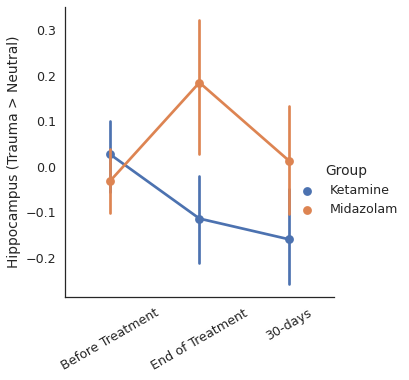

In [16]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Hippocampus (Trauma > Neutral)")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('hippo_pointGraph.png', dpi=300, bbox_inches='tight')

In [17]:
#df[['hippo1','hippo2','hippo3', 'hippo4','groupIdx']].groupby('groupIdx').describe()
df_long.groupby(['groupIdx','variable']).describe()

value                                                    \
                  count      mean       std       min       25%       50%   
groupIdx variable                                                           
0        hippo1    13.0 -0.031305  0.264194 -0.387857 -0.202330  0.006992   
         hippo2    12.0  0.184824  0.531310 -0.961320 -0.058206  0.131446   
         hippo3    10.0  0.013557  0.421124 -0.686757 -0.216576  0.119983   
1        hippo1    14.0  0.027460  0.283949 -0.564142 -0.055858  0.070363   
         hippo2    14.0 -0.113570  0.385519 -0.981734 -0.275992 -0.111625   
         hippo3    12.0 -0.158917  0.384423 -1.113694 -0.293271 -0.103110   

                                       
                        75%       max  
groupIdx variable                      
0        hippo1    0.227546  0.338373  
         hippo2    0.439066  1.051994  
         hippo3    0.306844  0.474120  
1        hippo1    0.222359  0.464944  
         hippo2    0.096493  0.500000  
         hippo3    0.027721  0.529858

Use time 1 as covariate to remove differences in baseline

In [3]:
## Load amygdala database
df = pd.read_csv('amg_TraumavsNeutral.csv')#('TraumavsNeutral_threeSes.csv')
# create a long format for analysis
df_long2 = pd.melt(df, id_vars=['scr_id','groupIdx', 'hippo1'], value_vars=['hippo2','hippo3'])
#df_long2

In [4]:
df_long2.to_csv('hippocampus_long2.csv', index=False)

In [4]:
# take indexes for building the model
df_long2['scr_id'] = df_long2.scr_id.astype('category')
sub_idx = df_long2.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long2.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long2.variable = pd.Categorical(df_long2.variable, 
                    categories=['hippo2','hippo3'])
timeIDX = df_long2.variable.cat.codes.values
print(timeIDX)
df_long2['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26]
27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sigma=0.1, shape=n_subs)
    cov = pm.Normal('cov', mu=0.05, sigma=0.1)
    b = pm.Normal('b', mu=0, sigma=0.1, shape=2)
    
    
   # bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=2) #
   # sigma = pm.HalfCauchy('sigma', 1)
    interact = pm.Normal('interaction', mu=0, sigma=1, shape=(2,2))
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + interact[timeIDX,df_long2.groupIdx] + cov*df_long2.hippo1

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long2.value)
    
    
    # calculate differences and effect size
    diff_of_means1 = pm.Deterministic('differenceGroups end of treatment', interact[0,1] - interact[0,0])
    diff_of_means2 = pm.Deterministic('differenceGroups 30 days', interact[1,1] - interact[1,0])
   
    # effect size
    effect_size1 = pm.Deterministic('effect size2_1', 
                        diff_of_means1 / eps)
    
    effect_size2 = pm.Deterministic('effect size3_1', 
                        diff_of_means2 / eps)
    
#     effect_size3 = pm.Deterministic('effect size4_1', 
#                         abs(diff_of_means3) / eps)
    
    ppChecks = pm.sample_prior_predictive(samples = 8000)
    trace = pm.sample(draws=10000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

/gpfs/ysm/project/joormann/oad4/conda_envs/pymc4/lib/python3.9/site-packages/pymc/model.py:1438: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, cov, b, interaction, eps, likelihood_missing]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 88 seconds.


In [12]:
az.summary(trace, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.007,0.095,-0.153,0.162,0.000,0.001,75317.0,28600.0,1.0
a[1],0.025,0.095,-0.129,0.184,0.000,0.001,80534.0,28879.0,1.0
a[2],-0.011,0.096,-0.171,0.146,0.000,0.001,67971.0,29852.0,1.0
a[3],0.031,0.095,-0.131,0.183,0.000,0.001,75420.0,29596.0,1.0
a[4],-0.013,0.096,-0.165,0.149,0.000,0.001,74350.0,29937.0,1.0
a[5],0.002,0.095,-0.147,0.166,0.000,0.001,69955.0,28444.0,1.0
a[6],-0.001,0.098,-0.160,0.162,0.000,0.001,73437.0,31327.0,1.0
a[7],0.000,0.096,-0.154,0.162,0.000,0.001,77858.0,29465.0,1.0
a[8],0.008,0.095,-0.143,0.168,0.000,0.001,78214.0,27694.0,1.0
a[9],-0.035,0.096,-0.190,0.125,0.000,0.001,78420.0,29659.0,1.0


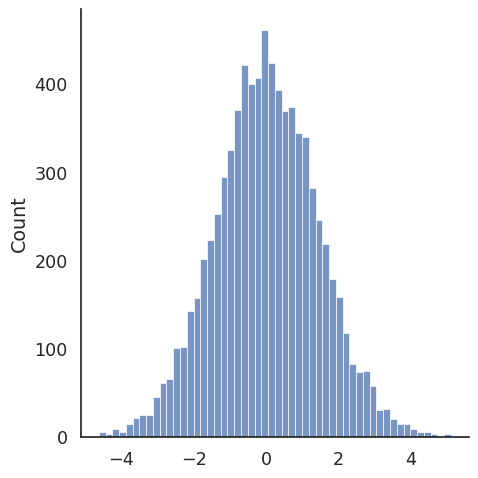

In [23]:
priorC = ppChecks['interaction'][:,0,0] - ppChecks['interaction'][:,0,1] 
sns.displot(priorC)

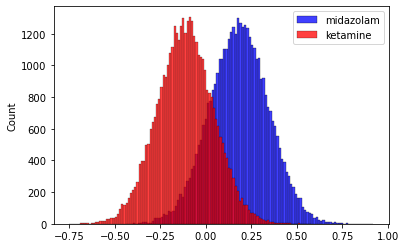

In [13]:
tr = trace.posterior.stack(draws=("chain", "draw"))
sns.histplot(tr.interaction.values[0,0,:,], label='midazolam', color='blue')
sns.histplot(tr.interaction.values[0,1,:], label = 'ketamine', color='red')
plt.legend()

<Axes: title={'center': 'effect size2_1'}>

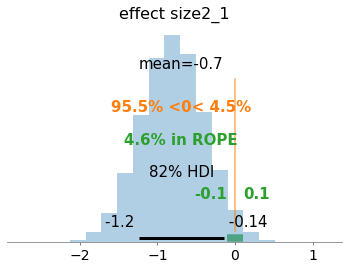

In [20]:
az.plot_posterior(trace, var_names='effect size2_1', ref_val=0,
                  rope=(-0.1,0.1), kind='hist', hdi_prob=.82)

0.0438


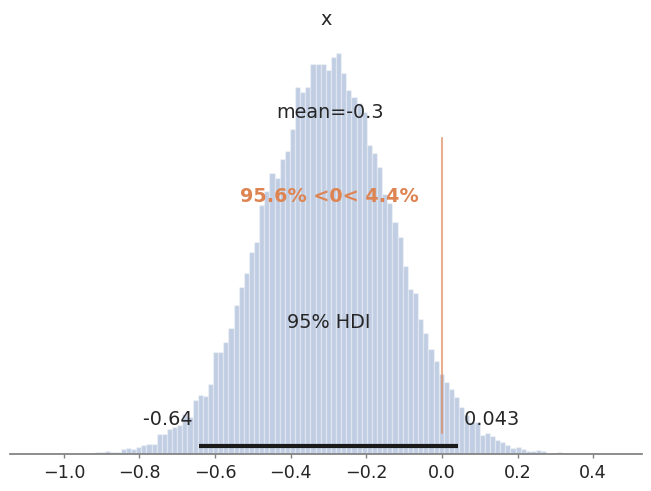

In [28]:
#tr.interaction.values[0,0,:,]
after = (tr.interaction.values[0,1,:,] - tr.interaction.values[0,0,:,])# / np.sqrt(
az.plot_posterior(after, kind='hist', ref_val=0, hdi_prob=.95)
print(np.sum(after>=0) / len(after))

In [27]:
from utils import calcBF
calcBF(y2=priorC, y1=after)

5.2493438320209975

## Bayes Factor

({'BF10': array([1.76687067]), 'BF01': array([0.56597238])},
 <Axes: title={'center': 'The BF_10 is 1.77\nThe BF_01 is 0.57'}, xlabel='effect size2_1', ylabel='Density'>)

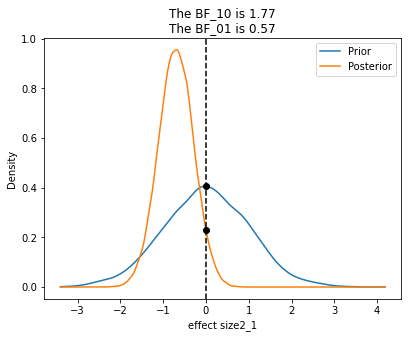

In [6]:
az.plot_bf(trace, var_name = 'effect size2_1', prior = np.random.normal(0, 1, 5000))

({'BF10': array([0.64940278]), 'BF01': array([1.53987637])},
 <Axes: title={'center': 'The BF_10 is 0.65\nThe BF_01 is 1.54'}, xlabel='effect size3_1', ylabel='Density'>)

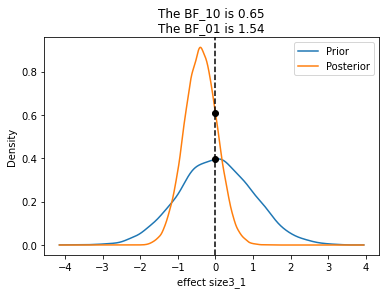

In [7]:
az.plot_bf(trace, var_name = 'effect size3_1', prior = np.random.normal(0, 1, 5000))

In [29]:
after2 = (tr.interaction.values[1,1,:,] - tr.interaction.values[1,0,:,])
calcBF(y1=priorC, y2=after2)

20.833333333333332

## Next we calculate the difference between the groups in each time
- Althgough the interaction wasn't significant, we still look at this one - as there's a group difference

In [30]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('hippo1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.032,0.084,-0.204,0.125,0.002,0.001,1759.0,1876.0,1.0
groupIdx,0.060,0.117,-0.175,0.278,0.003,0.002,1780.0,1841.0,1.0
sd,0.290,0.045,0.207,0.375,0.001,0.001,2119.0,1749.0,1.0


In [33]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('hippo2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.181,0.143,-0.093,0.464,0.003,0.002,1828.0,1901.0,1.0
groupIdx,-0.290,0.192,-0.644,0.088,0.005,0.003,1764.0,1890.0,1.0
sd,0.483,0.075,0.344,0.631,0.002,0.001,1820.0,1555.0,1.0


In [34]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('hippo3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.018,0.136,-0.204,0.248,0.003,0.002,1884.0,1814.0,1.0
groupIdx,-0.176,0.180,-0.465,0.127,0.004,0.003,1902.0,2435.0,1.0
sd,0.427,0.071,0.317,0.536,0.002,0.001,2017.0,1973.0,1.0


## Use a different way

In [35]:
## create a function that will simply run the model for each session
def runModel(variable):
    with pm.Model() as hierarchical:
        nu = pm.Gamma('nu',2,0.1)
        a = pm.Normal('a', mu=0, sd=1) 
        bMed = pm.StudentT('bMed', mu=0,nu=nu , shape=2) #

        # Model error
        eps = pm.HalfCauchy('eps', 5)

        y_hat = a + bMed[df.groupIdx]

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df[str(variable)])

        trace = pm.sample(draws=2000, tune=1000,target_accept=0.9, return_inferencedata=False, cores=4)
        diff = trace['bMed'][:,1] - trace['bMed'][:,0]
    return trace, diff

In [36]:
ses1trace, ses1Diff = runModel('hippo1')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, bMed, a, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


Group difference is 0.70075


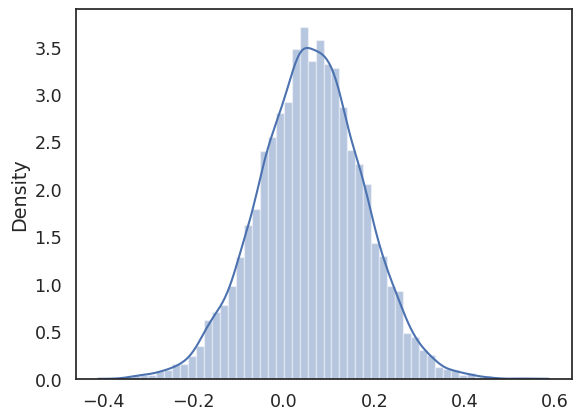

In [37]:
pm.summary(ses1trace)
sns.distplot(ses1Diff)
print(f'Group difference is {sum(ses1Diff>0)/len(ses1Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


Group difference is 0.058375


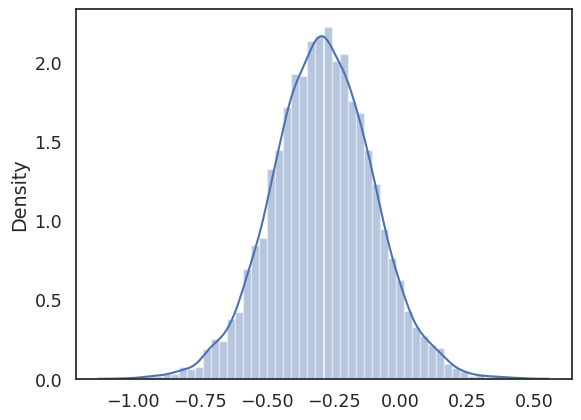

In [38]:
ses2trace, ses2Diff = runModel('hippo2')
pm.summary(ses2trace)
sns.distplot(ses2Diff)
print(f'Group difference is {sum(ses2Diff>0)/len(ses2Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Group difference is 0.17825


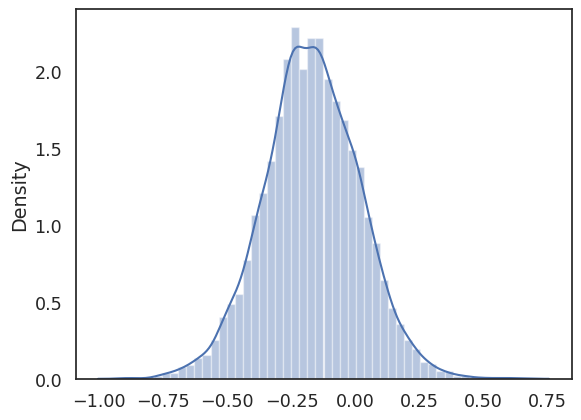

In [39]:
ses3trace, ses3Diff = runModel('hippo3')
pm.summary(ses3trace)
sns.distplot(ses3Diff)
print(f'Group difference is {sum(ses3Diff>0)/len(ses3Diff)}')

## Plotting

In [9]:
# set variables
def plotDiff(depVar,indepVar, trace):
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.025,.975])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                            'wspace':.1})
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
               linewidth = 3, linestyle = "-")

    #g3.set_ylim(-.7, .7)
    #ax1.set_ylim(-.7,.7)
    ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("Hippocampus reactivity to traumatic script", fontsize=12)
    ax1.set_xlabel("Group", fontsize=14)
    fig.savefig( str(depVar) + 'Reactivity.png', dpi=300, bbox_inches='tight')
    return fig

In [10]:
def plotSubfigs(subfigs,subNum, depVar,indepVar, trace, title):
    # gets subfig and the index number of it to plot the same as above
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.025,.975])
    axsLeft = subfigs[subNum].subplots(1,2, gridspec_kw={'width_ratios': [1, .2],'wspace':.01})
    ax1 = axsLeft[0]
    ax2 = axsLeft[1]
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                 boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
                linewidth = 3, linestyle = "-")

    ax2.set_ylim(-1,1)#(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax1.set_ylim(-1, 1)
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("Hippocampus reactivity to traumatic script", fontsize=12)
    ax1.set_xlabel('')#("Group", fontsize=14)
    ax1.set_title(title, fontsize=15)
    #ax1.title.set_style(font="large")

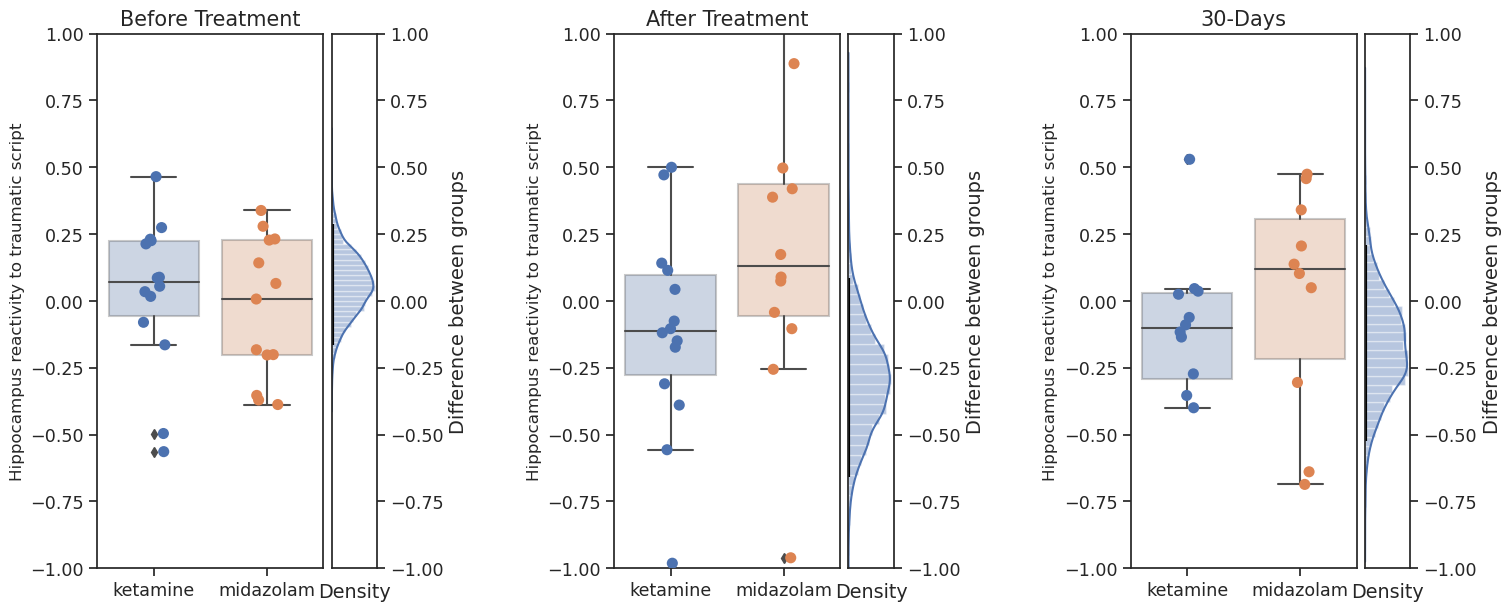

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
subfigs = fig.subfigures(1, 3, wspace=0.1)
plotSubfigs(subfigs, 0, 'hippo1','groupIdx',traceSes1, "Before Treatment")

plotSubfigs(subfigs, 1, 'hippo2','groupIdx',traceSes2, 'After Treatment')

plotSubfigs(subfigs, 2,'hippo3','groupIdx',traceSes3, '30-Days')

fig.savefig("Hipp_reactivity.png",  dpi=300, bbox_inches='tight')